In [36]:
import cv2 as cv
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os

import FileMangement
from FileMangement import *

In [37]:
def rgb2gray(rgb):
    # Sets each pixel to a weighted value
    return np.array(0.2126 * rgb[:,:,0] + 0.7152 * rgb[:,:,1] + 0.0722 * rgb[:,:,2])

# def rgb2gray(rgb):
#     # Sets each pixel to a weighted value
#     for x, row in enumerate(rgb):
#         for y, col in enumerate(row):
#             color = 0.2126 * rgb[x][y][0] + 0.7152 * rgb[x][y][1] + 0.0722 * rgb[x][y][2]
#             rgb[x][y][0] = color

#     return rgb

In [38]:
# Mask is a zero matrix
# fillMask fills an empty numpy array with 255 for pixels that fits inside the defined triangle
def fillMask(mask):
    h, w = mask.shape
    bottom_left = (h, 0)
    middle = (int(h/2), int(w/2))
    bottom_right = (h, w)
    
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            # Applying equations to left_bound and right_bound
            left_bound = (h - x) * middle[1] / middle[0]
            right_bound = x * middle[1] / middle[0]
            if y > left_bound and y < right_bound and x <= 400:
                mask[x][y] = 255
                
    return mask

In [39]:
# For each non-zero pixel in mask, the corresponding pixel on image is kept (the rest of the pixels in mask is discarded)
def apply_mask(image, mask):
    for x, row in enumerate(mask):
        for y, col in enumerate(row):
            if mask[x][y] != 255:
                image[x][y] = 0
    return image

In [40]:
def cropCar(img):
    for x, row in enumerate(img):
        for y, col in enumerate(row):
            if x > 400:
                img[x][y] = 0
    return img

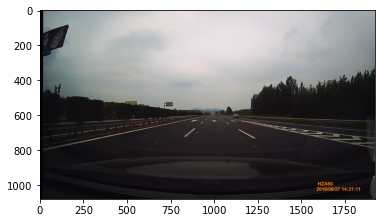

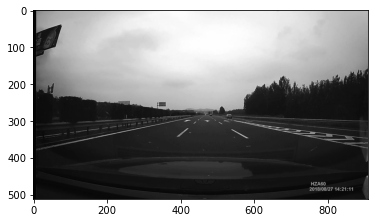

In [113]:
# Manual version takes a long time
# Read image from JPEG file
# Convert to grayscale

video_num = '0250'

frame_num = 900


pil_im = Image.open(get_image(video_num, frame_num))
orig = np.array(pil_im)
plt.imshow(orig)
plt.show()

# Resize so that standard height is 512
width = int(pil_im.width * 512 / pil_im.height)
pil_im = pil_im.resize((width , 512))

# Convert to np array
orig_img = np.array(pil_im)
# plt.imshow(orig_img)
# plt.show()

#Convert to grayscale
im = rgb2gray(orig_img)

# Deletes the 1 and 2 indices from the rgb parameter so the array can be squeezed
# im = np.delete(im, [1, 2], 2)

plt.imshow(im, cmap='gray')
plt.show()

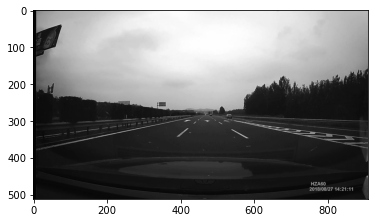

(512, 910)


In [114]:
# Squeeze the array into 2D space
im = np.squeeze(im)
plt.imshow(im, cmap='gray')
plt.show()
print(im.shape)

#Implementing image smoothing
rows = im.shape[0]
cols = im.shape[1]

#input any kernel size
kernel_shape_row = 7
kernel_shape_col = 7

kernel = np.ones((kernel_shape_row, kernel_shape_col))/(kernel_shape_row * kernel_shape_col)
mag_smooth = np.zeros((rows,cols))
print(kernel.shape)

#pad with zeros on the border for full blurring of image
padded_gray = np.zeros((rows + kernel_shape_row - 1, cols + kernel_shape_col - 1))
index_1_row = (int) ((kernel_shape_row - 1)/2)
index_last_row = (int) (rows + ((kernel_shape_row - 1)/2))
index_1_col = (int) ((kernel_shape_col - 1)/2)
index_last_col = (int) (cols + ((kernel_shape_col - 1)/2))
padded_gray[index_1_row:index_last_row, index_1_col:index_last_col] = im
# print(padded_gray.shape)

for x in range(rows):
    for y in range(cols):
        mag_smooth[x][y] = (kernel * padded_gray[x:x+kernel_shape_row, y:y+kernel_shape_col]).sum()     
        
# print(mag_smooth.shape)
plt.imshow(mag_smooth, cmap='gray')
plt.show()

In [115]:
# def get_lut(power=3):
#     return table

def increase_contrast(img, power=3):
    img = img.copy()
    for x, row in enumerate(img):
        for y, col in enumerate(row):
            if img[x][y] >= 200:
                if img[x][y] < 235:
                    img[x][y] += 20
                else:
                    img[x][y] = 255
            if img[x][y] < 200:
                if img[x][y] >= 125 :
                    img[x][y] -= 125
                else:
                    img[x][y] = 0
#     img = img.astype(np.int8)
#     table = np.array([(pow(i / 255.0, power) * 255) for i in np.arange(0, 256)]).astype(np.int8)
#     contrast = cv.LUT(img, table)
                
    return img

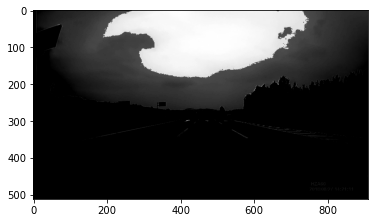

In [116]:
contrast_im = increase_contrast(im)
plt.imshow(contrast_im, cmap='gray')
plt.show()

(512, 910)


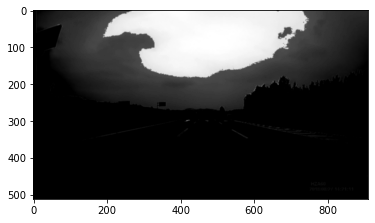

In [117]:
# Tharm's image smoothing
# Implementing image smoothing
rows = contrast_im.shape[0]
cols = contrast_im.shape[1]
print(im.shape)

kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9.0
# print(kernel)
mag_smooth = np.zeros((rows,cols))

# pad with zeros on the border for full blurring of image
padded_gray = np.zeros((rows + 2, cols + 2))
# print(img.shape)
padded_gray[1:-1, 1:-1] = contrast_im

for x in range(rows):
    for y in range(cols):
        mag_smooth[x][y] = (kernel * padded_gray[x:x+3, y:y+3]).sum()     
        
# print(mag_smooth.shape)
plt.imshow(mag_smooth, cmap='gray')
plt.show()

(512, 910)
finished making new image
(512, 910)


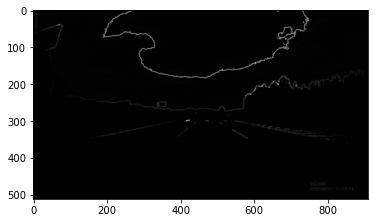

In [118]:
# Tharm's Sobel Edge Detector
## Implementing sobel edge detector
Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

mag_G = np.zeros((rows,cols))
#mag_G_thresh = np.zeros((rows,cols))
print(mag_G.shape)

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        sumx = (Gx * contrast_im[i-1:i+2, j-1:j+2]).sum()
        sumy = (Gy * contrast_im[i-1:i+2, j-1:j+2]).sum()
        mag_G[i][j] = np.sqrt(sumx**2 + sumy**2)
        
print('finished making new image')
print(mag_G.shape)
plt.imshow(mag_G, cmap='gray')
plt.show()

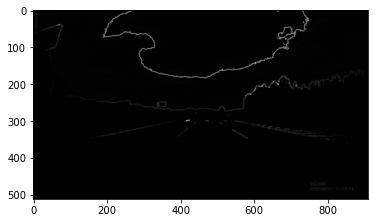

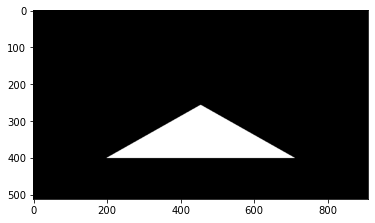

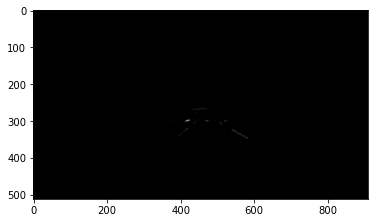

In [119]:
# Own implementation of cropped image
plt.imshow(mag_G, cmap='gray')
plt.show()
mask = np.zeros_like(mag_G)
mask = fillMask(mask)
plt.imshow(mask, cmap='gray')
plt.show()
cropped_im = apply_mask(mag_G, mask)
plt.imshow(cropped_im, cmap='gray')
plt.show()

In [120]:
cropped_im = cropCar(cropped_im)
# print(cropped_im.shape)

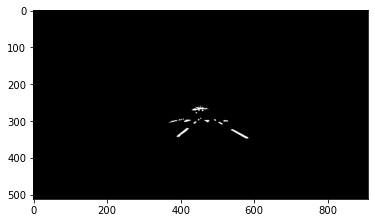

In [121]:

threshed = (cropped_im > 10).astype(np.uint8)
    
binary_lut = np.zeros(256).astype("uint8")
binary_lut[1:] = 255

threshed = cv.LUT(threshed.astype(np.uint8), binary_lut)

plt.imshow(threshed, cmap='gray')
plt.show()

In [122]:
# Rohit's code
def Hough_lines(img, line_length):

    height, width = img.shape[:2]
    
    # Creates the accumulator space
    accumulator = np.zeros([180, int(math.sqrt(height ** 2 + width ** 2))])

    lines = np.array([[0, 0], [0, 0]])

    #line_length = 40

    # look for every pixel
    for y in range(0, height):
        for x in range(0, width):
            # if pixel is white (possible part of a line)
            if img[y][x] > 250:
                # try all angles
                # Step = 3 to decrease number of lines
                for theta in range(0, 180, 1):
                    p = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
                    accumulator[theta][p] += 1
                    # Check if it looks like line and if it's not in a list
                    if (accumulator[theta][p] > line_length) and (p not in lines[:, 0]) and (theta not in  lines[:, 1]):
                        # lines is an array of [rho, theta] pairs that has a lot of points in the accumulator space
                        lines = np.vstack((lines, np.array([p, theta])))

    # clean two first zeros
    lines = np.delete(lines, [0, 1], axis=0)
    
#     print(lines)

    return accumulator, lines

In [123]:
# Rohit's code
# Outputs 2 different points on the line to draw the line
def hough_intersect (rho, theta, image):
    h, w = image.shape[:2]
    out = []
    theta = math.radians(theta)
    intersect = [int(round(rho / math.sin(theta))), int(round((rho - w * math.cos(theta)) / math.sin(theta))), int(round(rho / math.cos(theta))),
                 int(round((rho - h * math.sin(theta)) / math.cos(theta)))]
#     print(intersect)
    if (intersect[0] > 0) and (intersect[0] < h):
        out.append((0, intersect[0]))
    if (intersect[1] > 0) and (intersect[1] < h):
        out.append((w, intersect[1]))
    if (intersect[2] > 0) and (intersect[2] < w):
        out.append((intersect[2], 0))
    if (intersect[3] > 0) and (intersect[3] < w):
        out.append((intersect[3], h))    
    
#     print(out)
    return out

In [136]:
hough_space, point_stack = Hough_lines(threshed, 55)

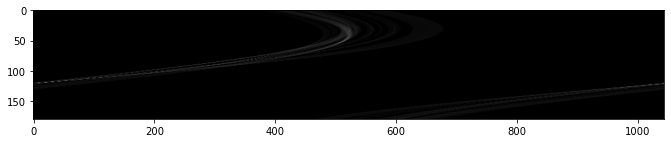

In [137]:
plt.figure(figsize = (20,2))
plt.imshow(hough_space, cmap='gray')
plt.show()

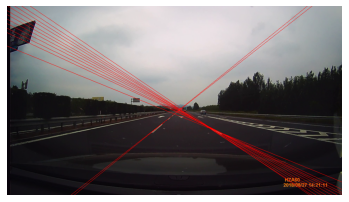

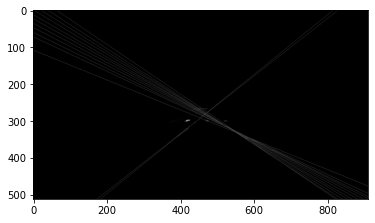

In [138]:
points_coord = [] #To store the coordinates of the lines
orig_line = orig_img.copy()
edge_line = cropped_im.copy()

for i in point_stack:
    points = hough_intersect(i[0], i[1], orig)
#     print(points)
    if (len(points) > 1):
        points_coord.append([list(point) for point in points])
        cv.line(orig_line, points[0], points[1], (255,0,0))
        cv.line(edge_line, points[0], points[1], (255,255,255))
        
# cv.line(orig_img, (250, 250), (200, 300), (0,0,255))

fig = plt.imshow(orig_line)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.show()
plt.imshow(edge_line, cmap="gray")
plt.show()